In [43]:
# import libraries
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.ensemble import RandomForestClassifier

In [44]:
# load data
data = pd.read_csv("shuffled-full-set-hashed.csv", names=['Category', 'Documents'])

BILL                       18959
POLICY CHANGE              10616
CANCELLATION NOTICE         9729
BINDER                      8952
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4367
DECLARATION                  967
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
INTENT TO CANCEL NOTICE      229
APPLICATION                  229
Name: Category, dtype: int64


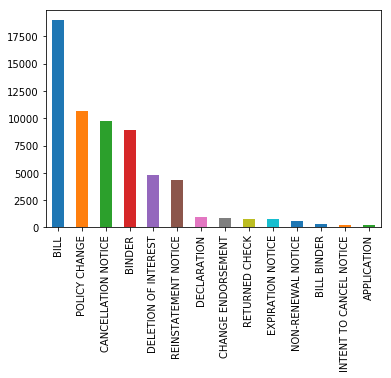

In [45]:
# clean the data by removing all NaN values
data.dropna(inplace=True)

# data exploration
pd.value_counts(data['Category']).plot.bar()
unique_categories = data['Category'].value_counts()
print(unique_categories)

In [46]:
# create respective lists of categories and documents
doc_type = data['Category'].values.tolist()
doc = data['Documents'].values.tolist()

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(doc, doc_type, test_size=0.3)

In [47]:
# tokenization - add all documents in a list
documents = []
for string in x_train:
    documents += string.split(" ")

In [48]:
# calculate the frequency
frequency = nltk.FreqDist(documents)
print(frequency)

<FreqDist with 789874 samples and 14555061 outcomes>


In [49]:
# store the documents having highest frequency
top_docs = frequency.most_common(250)
features = [i[0] for i in top_docs]
pickle.dump(features, open('feature.pkl', 'wb'))

In [50]:
# build a dictionary to respresent how many frequent words are present in a particular row 
def get_feature_dict(words):
    current_features = {}
    words_set = set(words)
    for w in features:
        current_features[w] = w in words_set
    return current_features

In [51]:
# convert arrays of training and testing data
training_set = []
for i in range(len(x_train)):
    training_set.append(((x_train[i]),y_train[i]))
testing_set = []
for i in range(len(x_test)):
    testing_set.append(((x_test[i]),y_test[i]))

In [52]:
# array of dictionary of training set 
training_data = [(get_feature_dict(string.split(" ")), category) for string,category in training_set]

In [53]:
# array of dictionary of testing set 
testing_data = [(get_feature_dict(string.split(" ")), category) for string, category in testing_set]

In [54]:
# Random Forest Classifier model
rfc = RandomForestClassifier()
rfc = RandomForestClassifier(n_estimators=90,min_samples_split=5,min_samples_leaf=2,max_features='auto',bootstrap=False)
RFC_classifier = SklearnClassifier(rfc)
RFC_classifier.train(training_data)
print("Accuracy:", (nltk.classify.accuracy(RFC_classifier, testing_data))*100)

Accuracy: 86.54547404547405


In [55]:
# save the classifier
pickle.dump(RFC_classifier, open('model.pkl', 'wb'))

In [56]:
# getting array of dictionaries of testing set
dict_testX = [(get_feature_dict(string.split(" "))) for string, category in testing_set]

In [57]:
# getting array of labels on testing set
ytest = [category for string, category in testing_set]

In [58]:
# predicted value from the classifier
prediction = LogisticRegression_classifier.classify_many(dict_testX)

In [59]:
# confusion matrix
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(35,22)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

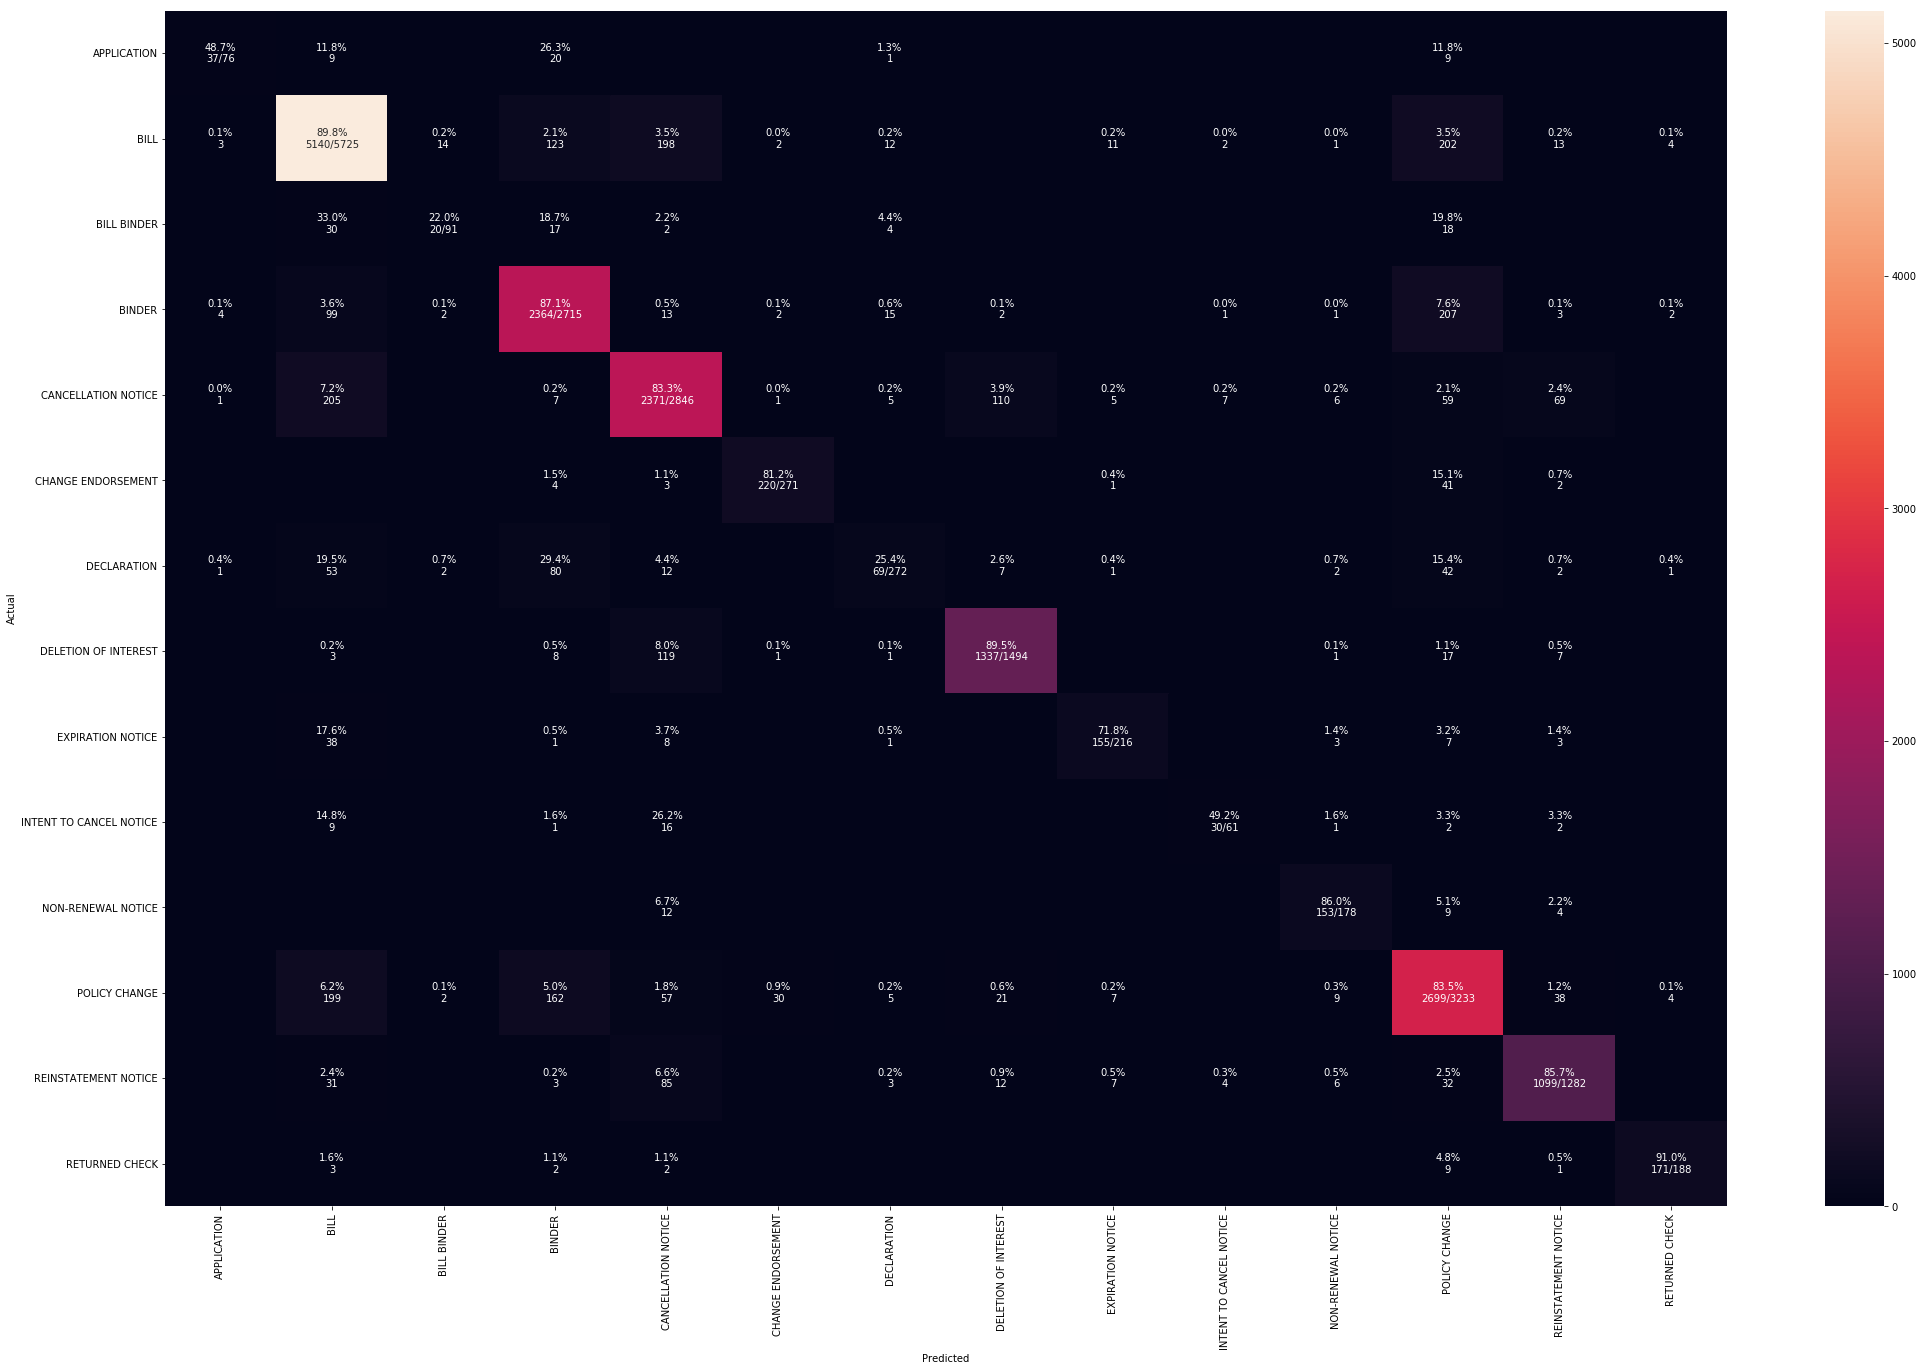

In [60]:
label = np.unique(ytest)
cm_analysis(ytest, prediction, label)